# Satruation curve script. 

Here I plan to write a small script that can be used to just produce saturation curves for Contrast vs Y graphs, where Y is most likely eithe microwave or laser power, however this does not need to be exclusively the case (hopefully). 

In [1]:
import numpy as np 
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plot 
import os

In [2]:
def get_data_to_pandas(file_path):
    '''Take the file name and load the data into a pandas dataframe ready for analysis.'''
    
    params_data = pd.read_table(file_path) 
    return(params_data)

In [3]:
def sat_curve(P_uw, c_inf, P_sat):
    '''Equation to calcualte the saturaton curve for given data arrays.'''
    # p_uW = power sweep
    # y = Contrast as a functin of applied power, 
    # c_inf = maximum ODMR contrast
    # P_sat = stauration power.
    
    y = (c_inf * P_uw)/(P_uw + P_sat)
    
    return(y)
    

In [4]:
def power_curve_optimisation(x, y, P0):
    '''The saturation curve optimisation code.
    Outputs the coefficients of the curve fitting and the associated error.'''
    P = P0 # inital values variable.
    
    coeffs, confidence = opt.curve_fit(sat_curve, x, y, P) # curve fit optimization
    opt_error = np.sqrt(np.diag(confidence)) # error calculation
    
    return(coeffs, opt_error)

In [5]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 20})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

In [6]:
def straight_line(x, m, c):
    '''Straight line fitting'''
    
    y = m*x + c
    return (y)

In [7]:
def sqrt_fit(x, a, b, c): 
    
    y = a*np.sqrt(b*x) + c
    return(y)

In [8]:
def dc_sensitivity(line_width, error_FWHM, contrast, intensity, NV_number):
    '''A calculation for the sensitvity of the NV centre (ensemble) used for 
    DC magnetic field sensitivity. Calulated using the equatuin presented in: 
    https://iopscience.iop.org/article/10.1088/2399-1984/ab5f9b/pdf
    
    equation: 
    eta = h / (g*mu_B) * line_width / (sqrt(I0) * Contrast)'''
    
    g_NV = 2.002 # Lande Factor
    mu_B = 9.27 # Bohr Magneton
    h = 6.626  # Planck Constant.
    
    power_h = -34 # power of plank constant
    power_mu_B = -24 # power of bohr magneton
    power_line_width = 9 # power of Giga Hertz
    
    total_power = power_h - power_mu_B # Total power for the 
    
    line_width = line_width * (10**power_line_width) # Convert to Hertz
    
    sqrt_intensity = np.sqrt(intensity * 100) # Convert to seconds
    
    eta_a = (h/(g_NV*mu_B)) # First fraction of the equation
    
    # Calculate the second fraction of the equation.
    eta_b_num = line_width 
    eta_b_denom = (sqrt_intensity * contrast * 100 *np.sqrt(NV_number))# convert to percentage
    
    eta_b = eta_b_num / eta_b_denom 
    
    # For trouble shooting, each phase of the sensitivity calculation has been broken into 
    # simple parts. 
    
    eta_c = eta_a * eta_b
    # Calculate sensitivity
    eta = eta_c*10**(total_power)    
    
    ### Calculating the error in sensitvity.
    
    delta_FWHM = error_FWHM # Error in FWHM
    delta_I0 = np.sqrt(intensity*100) # error in Off-resonant intensity (I0).
    delta_sqrt_I0 = 0.5 * 1/(intensity*100) # Error in sqrt(I0)

    # Error in fitted contrast measurment. 
    delta_contrast = contrast * np.sqrt( ( 1/np.sqrt( intensity*100 ) )**2 
                                           + ( 1/np.sqrt(contrast * intensity ) )**2 )

    # Fractional errors for the three variables recorded from measurement. 
    a = (delta_FWHM/FWHM)
    b = (delta_sqrt_I0/delta_I0)
    c = (delta_contrast/contrast)

    # Error in sensitivity. 
    delta_eta = eta * np.sqrt( a**2 + b**2 + c**2 )
    
    return(eta, delta_eta)

### Script starts here

[ 3.85227638 -3.62736967] [0.4427773  1.68873587]


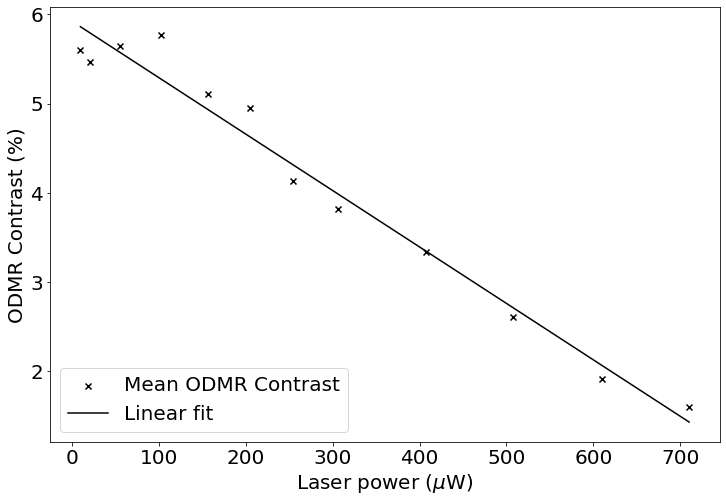

In [53]:
# Start with the file name and location: 
folder_location = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\ODMR\\20210913\\'
date = '20210913'
file_name = '20210913_reference_ODMR_analysis'
set_plot_params()
# Open the file and copy the data into a pandas array. 
data_set = get_data_to_pandas(folder_location + file_name + '.dat')

## Applied powers not saved into the dataset, so need to create the applied power array 
## manually. 

laser_power = np.array([10, 20.5, 55, 103.1, 156.8, 204.7, 254, 306, 407, 507, 610, 710]) # microWatt

contrast = np.array([5.598017064, 5.467404184, 5.648122934, 5.767238187, 5.104586753, 4.950111106,
                    4.126812481, 3.820744243, 3.337558162, 2.605370713, 1.908325985, 1.596677262])

mean_fluorescence = data_set['Off Res Fluorescence intensity (per dwell time)']

contrast_error = contrast * ((contrast*mean_fluorescence[1:])/mean_fluorescence[1:])

fig, ax = plot.subplots()

plot.scatter(laser_power, contrast, marker = 'x', color = 'k',
            label = 'Mean ODMR Contrast')

# Inital parametes for the saturation curve fitting.
P0 = [1,1]
# Find the saturation curve fitting parameters
fit_params, error = power_curve_optimisation(laser_power, contrast, P0)

# Create the arrays used for fitting the saturation curve.
x_fit = np.linspace(max(laser_power), min(laser_power), 50)
y_fit = sat_curve(x_fit, fit_params[0], fit_params[1])

p1 = [1, 1]
fit_2, con_2 = opt.curve_fit(straight_line, laser_power, contrast, p1)

y_fit_2 = straight_line(x_fit, fit_2[0], fit_2[1])

plot.plot(x_fit, y_fit_2, label = 'Linear fit', color = 'k')
plot.xlabel(r'Laser power ($\mu$W)')
plot.ylabel('ODMR Contrast (%)')
plot.legend( loc = 'lower left')
set_plot_params()
print(fit_params, error)
#fig.savefig('H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\20210913\\' + date+'_Contrast_vs_laserPower.pdf')

2.8548839949037015e-07
5.11254476560698e-08


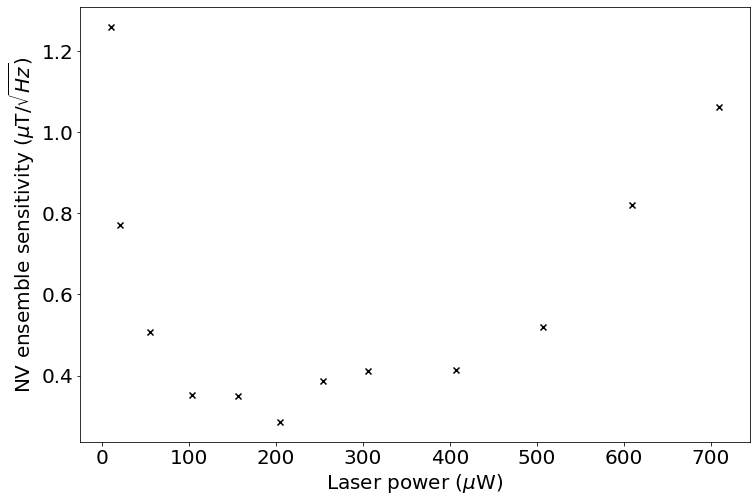

In [56]:
fwhm1 = data_set['FWHM 1 (MHz)']
fwhm2 = data_set['FWHM 2 (MHz)']
error_fwhm1 =  data_set['FWHM 1 error (MHz)']
error_fwhm2 =  data_set['FWHM 1 error (MHz)']

FWHM = np.sqrt(fwhm1**2 + fwhm2**2)
FWHM_error = FWHM * np.sqrt( (error_fwhm1/fwhm1)**2 + (error_fwhm2/fwhm2)**2 )


eta, eta_error = dc_sensitivity(FWHM[1:], FWHM_error[1:], contrast, mean_fluorescence[1:], 10)
fig1, ax1 = plot.subplots()
plot.scatter(laser_power, eta*10**6, marker = 'x', color = 'k')
plot.xlabel(r'Laser power ($\mu$W)')
plot.ylabel(r'NV ensemble sensitivity ($\mu$T/$\sqrt{Hz}$)')

print(np.min(eta))
print(eta_error[5])

fig1.savefig('H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\20210913\\' + date +'_sensitivity_vs_laserPower.pdf')

[30440.21052222   592.42065888]


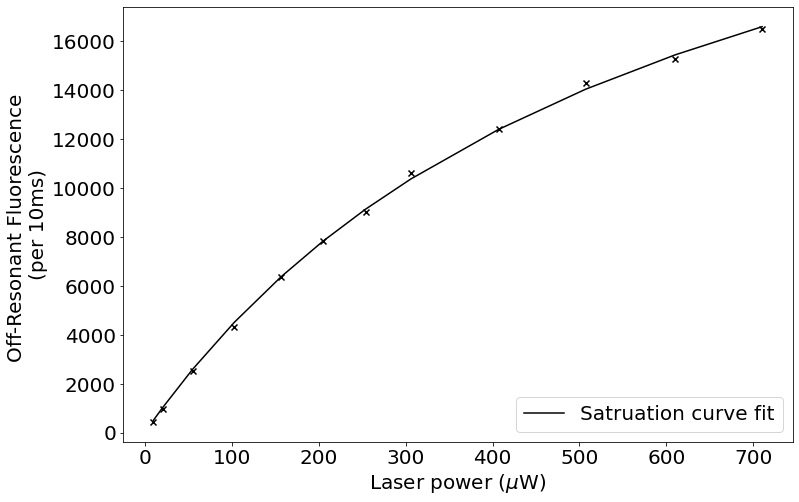

In [50]:
fig2, ax2 = plot.subplots()
plot.scatter(laser_power, mean_fluorescence[1:], marker = 'x', color = 'k')
plot.xlabel(r'Laser power ($\mu$W)')
plot.ylabel('Off-Resonant Fluorescence \n(per 10ms)')

p0 = [30000, 550]
lower_bound  = [0, 0]
upper_bound = [np.inf, 1000]
fit_params, error = opt.curve_fit(sat_curve, laser_power, mean_fluorescence[1:], P0, 
                                 bounds = (lower_bound, upper_bound))

y_fit = sat_curve(laser_power, fit_params[0], fit_params[1])

print(fit_params)
plot.plot(laser_power, y_fit, color = 'k',
         label = 'Satruation curve fit')
plot.legend(loc = 'lower right')
fig2.savefig('H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\20210913\\' + date+'_OffResCounts_vs_laserPower.pdf')

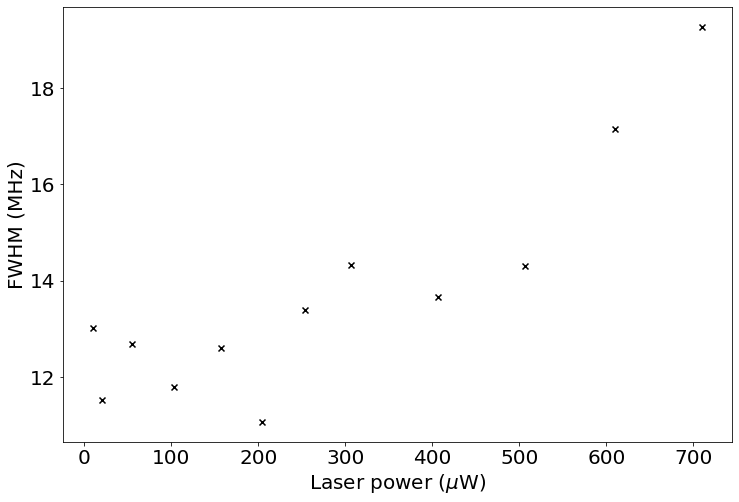

In [51]:
fig3, ax3 = plot.subplots()
plot.scatter(laser_power, FWHM[1:], color = 'k', marker = 'x')
plot.xlabel(r'Laser power ($\mu$W)')
plot.ylabel('FWHM (MHz)')
fig3.savefig('H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\20210913\\' + date+'_FWHM_vs_laserPower.pdf')

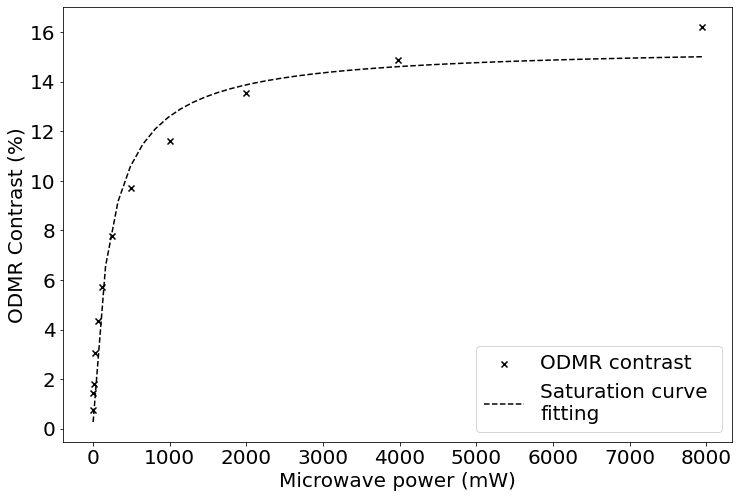

In [11]:
fig,ax = plot.subplots()
plot.scatter(power_mW, data_set['Contrast (%)'][0:12], marker = 'x', color = 'k', 
            label = 'ODMR contrast')
plot.xlabel('Microwave power (mW)')
plot.ylabel('ODMR Contrast (%)')

plot.plot(x_fit, y_fit, color = 'k', linestyle = '--', label = 'Saturation curve \nfitting')
plot.legend()
plot.savefig('H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\20210607\\' + date + '_Microwave_power_sat_curve' + '.pdf')

In [18]:
#fig.savefig(folder_location + date + '_Microwave_power_sat_curve' + '.pdf')

0.13932319704920712 4.605228473473118


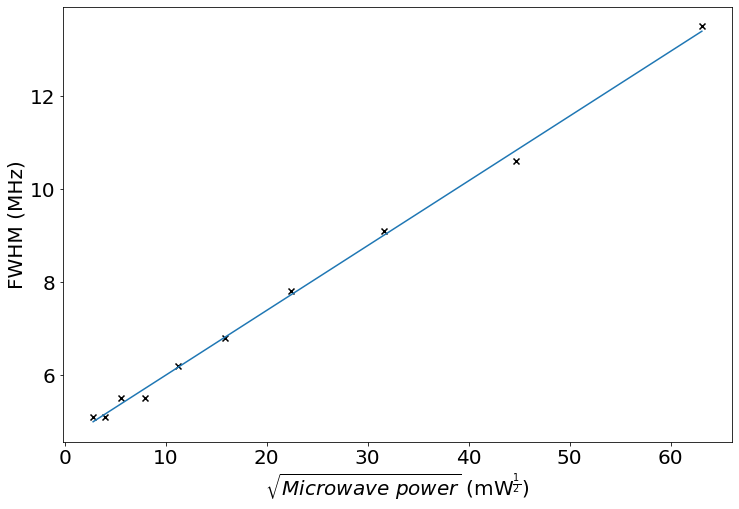

In [33]:
FWHM = np.array([13.5, 10.6, 9.1, 7.8, 6.8, 6.2, 5.5, 5.5, 5.1, 5.1])
sub_power_mW = np.sqrt(power_mW[0:len(FWHM)])
plot.scatter(sub_power_mW, FWHM, marker = 'x', color = 'k')
plot.xlabel(r'$\sqrt{Microwave ~power}$' + r' (mW$^{\frac{1}{2}})$')
plot.ylabel('FWHM (MHz)')

P = [1, 1]
coeffs, confidence = opt.curve_fit(straight_line, sub_power_mW, FWHM, P) # curve fit optimization
opt_error = np.sqrt(np.diag(confidence)) # error calculation

y = straight_line(sub_power_mW, coeffs[0], coeffs[1])
plot.plot(sub_power_mW, y)
print(coeffs[0], coeffs[1])

In [57]:
10**(35/10)

3162.2776601683795